## Skip-Grams

In [2]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### 下载压缩文件和核对大小

In [3]:
url = "http://mattmahoney.net/dc/"

def maybe_download(filename,expected_bytes):
    if not os.path.exists(filename):
        filename,_ = urllib.request.urlretrieve(url+filename,filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified',filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify '+filename+'.Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip',31344016)

Found and verified text8.zip


#### 得到包含17005207个单词的列

In [7]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print("Data size",len(words))

Data size 17005207


In [13]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

#### word2int,int2word

In [15]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['unk',-1]] #-1代表unk的数量
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    return data,count,dictionary,reverse_dictionary
# data:words中所有词对应的索引
# count:[[词,频数]]
# dictionary:词：索引
# reverse_dictionaty:索引：词

data,count,dictionary,reverse_dictionary = build_dataset(words)

In [18]:
# del words # 防止占内存
print("Most common words (+UNK)",count[:5])
print("\n")
print('Sample data',data[:10],[reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['unk', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]


Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


#### batch and labels

In [22]:
data_index = 0
def generate_batch(batch_size,num_skips,skip_window):
    """
    num_skips:每个单词产生多少个样本
    bacth_size必须是num_skips的整数倍
    batch:样本集合
    
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size),dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1),dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index =(data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window # 第skip_window个变量为目标词汇
        targets_to_avoid = [skip_window] #生成样本时要避开的词汇，初始时包含目标词汇本身
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0,span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j,0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch,labels

In [24]:
#test
batch,labels = generate_batch(batch_size=8,num_skips=2,skip_window=1)
for i in range(8):
    print(batch[i],reverse_dictionary[batch[i]],'->',labels[i,0],reverse_dictionary[labels[i,0]],'\n')

59 used -> 46 first 

59 used -> 156 against 

156 against -> 59 used 

156 against -> 128 early 

128 early -> 156 against 

128 early -> 742 working 

742 working -> 477 class 

742 working -> 128 early 



In [28]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window,valid_size,replace=False)
num_sampled = 64 #负样本个数

In [26]:
valid_examples

array([52, 92, 96,  4, 45, 25, 39, 68, 56, 27, 95,  2,  3, 85, 89, 69])

#### 构建框架图

In [32]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32,shape=[batch_size])
    train_labels = tf.placeholder(tf.int32,shape=[batch_size,1])
    valid_dataset = tf.constant(valid_examples,dtype=tf.int32)
    
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
        embed = tf.nn.embedding_lookup(embeddings,train_inputs)

        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                        biases=nce_biases,
                                        labels=train_labels,
                                        inputs=embed,
                                        num_sampled=num_sampled,
                                        num_classes=vocabulary_size))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1,keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
    similarity = tf.matmul(valid_embeddings,normalized_embeddings,transpose_b=True) #计算验证单词与所有嵌入单词的相似性

    init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [40]:
num_steps = 100001

with tf.Session(graph=graph)as session:
    init.run()
    print("Initialized")
    
    average_loss = 0
    for step in range(num_steps): #每次迭代只训练一个batch
        batch_inputs,batch_labels = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_inputs:batch_inputs,train_labels:batch_labels}
        
        _,loss_val = session.run([optimizer,loss],feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print("Average loss at step ",step,": ",average_loss)
            average_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1] # argsort（从小到大的索引号）；除自己外，最相似的前8个
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str,close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  258.88311767578125
Nearest to new: mindful, milton, revitalization, relator, heroin, alliteration, bern, unite,
Nearest to who: culminated, ensuing, allosteric, lusitanian, postulates, bluff, convenience, constructible,
Nearest to was: clash, capoeira, monolithic, irl, libra, apes, keg, militiamen,
Nearest to by: mccormack, having, phenylalanine, tolkien, salvaged, rex, code, corrupting,
Nearest to a: landing, hires, divers, oligopoly, bowstring, seaman, lord, golovachev,
Nearest to history: minardi, scriptura, chuppah, unicellular, hedonistic, greenhouse, immortal, meager,
Nearest to their: instructing, masoretes, thoroughfares, antiquarian, hirsch, industrial, fungal, uz,
Nearest to on: motherhood, nosed, length, believable, adults, hyphen, amadeus, infringes,
Nearest to he: indistinguishable, hep, float, wallis, atalanta, fidelity, axons, giles,
Nearest to th: bash, umno, rutgers, bruford, knuckle, emissions, meson, texts,
Nearest to after: dar

Average loss at step  52000 :  5.17297053706646
Average loss at step  54000 :  5.101635481834411
Average loss at step  56000 :  5.066307352304459
Average loss at step  58000 :  5.0913909817934035
Average loss at step  60000 :  4.941439141690731
Nearest to new: milton, great, signing, cebus, doris, callithrix, family, bambaataa,
Nearest to who: he, which, they, also, and, albury, often, not,
Nearest to was: is, has, were, had, by, became, been, when,
Nearest to by: was, be, as, with, microcebus, were, cebus, agouti,
Nearest to a: the, backslash, another, any, callithrix, dasyprocta, dist, governorates,
Nearest to history: callithrix, cebus, mathbf, intact, agouti, microsite, abet, gb,
Nearest to their: its, his, the, her, callithrix, microcebus, phi, agouti,
Nearest to on: in, abet, at, from, michelob, upon, mathbf, gland,
Nearest to he: it, they, she, there, who, microsite, albury, microcebus,
Nearest to th: eight, six, seven, nine, zero, four, checkers, five,
Nearest to after: when, b

> t.eval()时，等价于：tf.get_default_session().run(t).

In [46]:
normalized_embeddings[:5,:]

<tf.Tensor 'strided_slice_1:0' shape=(5, 128) dtype=float32>

In [45]:
final_embeddings[:5,:]

array([[-5.66970855e-02,  1.31650642e-01, -1.34490386e-01,
        -4.80807163e-02, -7.88416117e-02, -8.53181630e-03,
        -3.64548154e-02, -1.39574692e-01,  1.48069680e-01,
        -1.07848413e-01,  1.56800449e-02, -1.16830587e-01,
        -1.03125826e-01,  7.58625939e-02,  1.50168821e-01,
        -1.04511771e-02, -2.99579874e-02,  5.83832189e-02,
         1.21270426e-01,  1.62891522e-01, -4.27977555e-03,
         3.52733186e-03,  4.37505543e-02,  8.84386078e-02,
         5.83380833e-02, -5.25032207e-02, -7.32320398e-02,
         1.16017729e-01,  5.35150953e-02, -1.63356096e-01,
         1.26650827e-02,  1.45068884e-01, -1.31143987e-01,
        -4.72605526e-02,  8.51690210e-03, -1.49133205e-01,
        -6.38418049e-02, -1.33740738e-01, -4.77596708e-02,
        -6.76517412e-02, -6.15881756e-02, -1.60446763e-02,
         7.89611042e-02, -1.36504359e-05,  2.44749878e-02,
         1.06033936e-01,  5.03512099e-02,  2.34616026e-02,
        -1.83766171e-01, -6.33329749e-02,  1.69759262e-0

#### 可视化

In [43]:
def plot_with_labels(low_dim_embs,labels,filename='pictures/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels),"More labels than embeddings"
    plt.figure(figsize=(18,18))
    for i,label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    plt.savefig(filename)

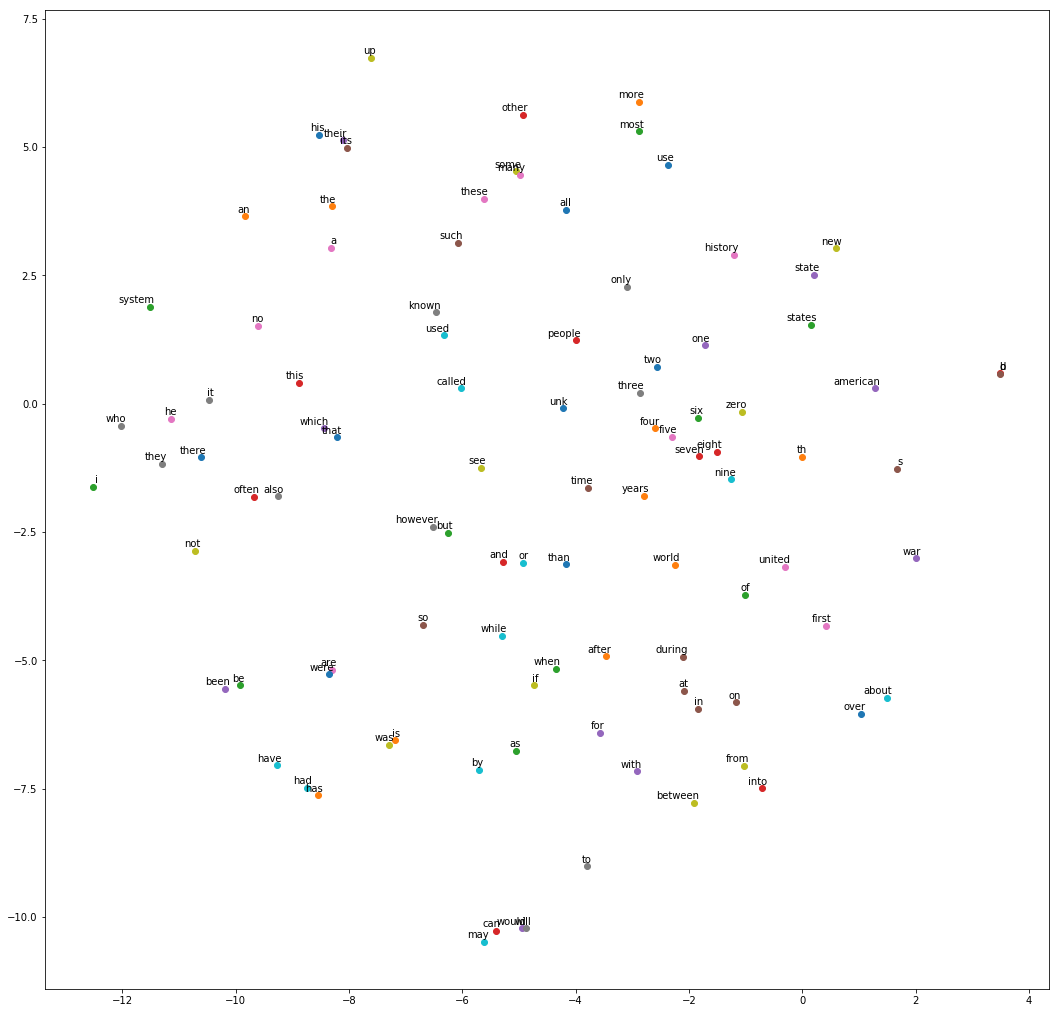

In [44]:
#降维
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000) #压缩到两个维度
plot_only=100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs,labels)